# How to create a simulation Model for cdsaxs?

First let's start by doing necessary imports (make sure that cdsaxs is installed in your environment).

In [7]:
import numpy as np
import pandas as pd
from cdsaxs.simulations.base import Simulation, Geometry

### Create the Simulation Class

   Your simulation class should inherit from the `Simulation` protocol. This class is where the core logic of your simulation resides. It should use the geometric data from the `Geometry` class to set up and run the simulation.

   Ensure that the `simulate_diffraction` method is implemented to perform the simulation. Depending on the complexity of your model, this method might involve extensive calculations or integrations.

   If your simulation will be used in conjunction with a `Fitter` class, make sure to implement the `set_from_fitter` method. This will enable your simulation to correctly handle data provided by the `Fitter` and return results in a format that the `Fitter` can use.


In [8]:
class CylinderSimulation(Simulation):
    """A class representing a simulation of a cylinder for diffraction pattern calculation."""

    def __init__(self, qys, qzs, from_fitter=False, initial_guess=None):
        """Initializes the CylinderSimulation object.

        Args:
            qys (array-like): The q-values in the y-direction for diffraction calculation.
            qzs (array-like): The q-values in the z-direction for diffraction calculation.
            from_fitter (bool, optional): Indicates if the parameters should be taken from the fitter. Defaults to False.

        """
        self.qys = qys
        self.qzs = qzs
        self.from_fitter = from_fitter
        self.CylinderGeometry = CylinderGeometry(from_fitter=from_fitter, initial_guess=initial_guess)
        self.CylinderDiffraction = CylinderDiffraction(CylinderGeometry=self.CylinderGeometry)

    def simulate_diffraction(self, params=None):
        """Simulates the diffraction pattern of the cylinder.

        Args:
            params (dict, optional): Parameters for the cylinder. Defaults to None.
        Returns:
            intensity (array-like): A 2D array of floats containing the intensity.
        """        
        intensity = self.CylinderDiffraction.calculate_intensity(self.qys, self.qzs, params)

        if not self.from_fitter:
            return intensity[0]

        return intensity
    
    def set_from_fitter(self, from_fitter):
        """Sets the parameters of the simulation from the fitter.

        Args:
            from_fitter (Fitter): The fitter object.
        """
        self.from_fitter = from_fitter
        self.CylinderGeometry.from_fitter = from_fitter
        #You can also use this method to do all the intialization neccesary for fitting.
        self.CylinderGeometry.set_initial_guess_dataframe()

    @property
    def geometry(self):
        """Returns the geometry of the simulation. This is necessary so that any external object can access the geometry of the simulation
        without having to know the internal structure of the simulation object.

        Returns:
            CylinderGeometry: The geometry of the simulation.
        """
        return self.CylinderGeometry

### Define the Geometry Class

   Create a class that implements the `Geometry` protocol. This class should define the specific geometric properties of the system being simulated. For example, in a model of stacked trapezoids, this class would define the dimensions, angles, and positions of the trapezoids.

   Implement the `convert_to_dataframe` method to organize the input parameters into a structured format suitable for the simulation. This method is crucial for ensuring that the parameters can be easily interpreted and manipulated by the `Fitter` class.


In [9]:
class CylinderGeometry(Geometry):
    """A class representing the geometry of a cylinder."""

    def __init__(self, from_fitter=False, initial_guess=None):
        """Initializes the CylinderGeometry object.

        Args:
            from_fitter (bool, optional): Indicates if the parameters should be taken from the fitter. Defaults to False.
        """
        self.from_fitter = from_fitter
        self.initial_guess = initial_guess
        self.initial_guess_dataframe = None

    def set_initial_guess_dataframe(self):
        """if the function is being called by the fitter this function sets the initial guess for the parameters.

        Args:
            initial_guess (dict): The initial guess for the parameters.
        """
        self.initial_guess_dataframe = pd.DataFrame(self.initial_guess, index=[0])

    def convert_to_dataframe(self, params):
        """Converts the parameters to a DataFrame.

        Args:
            params (dict or array): The parameters of the cylinder.
        Returns:
            df (DataFrame): A DataFrame containing the parameters.
        """
        if self.from_fitter:
            df = self.rescale_fitparams(params)
            
        else:
            df = pd.DataFrame(params, index=[0])

        return self.check_physical_validity(df)
    
    def check_physical_validity(self, params_df):
        """Checks if the parameters are physically valid. In this case, the radius and length of the cylinder should be positive.

        Args:
            params_df (DataFrame): A DataFrame containing the parameters.
        Returns:
            params_df_c (DataFrame): A DataFrame containing the parameters that are physically valid.
        
        """

        
        params_df_c = params_df.copy()
        keys = params_df_c.columns
        
        for key in keys:
            if params_df[key].values[0] < 0:
                params_df_c.loc[params_df_c[key] < 0, key] = np.nan

        return params_df_c

    def rescale_fitparams(self, params):
        """Rescales the parameters of the cylinder. Here the multiplier is hardcoded for ease but it should ideally be user input values.

        Args:
            df (DataFrame): A DataFrame containing the parameters.
        Returns:
            df (DataFrame): A DataFrame containing the rescaled parameters.
        """

        multiples = np.array([5 , 5, 1])#hardcoded for now but user input values recommended

        df = pd.DataFrame(params, columns=self.initial_guess_dataframe.columns)
        
        df = df * multiples
        
        df = df + self.initial_guess_dataframe.loc[0]

        return df

### Separating the diffraction logic from the geometry

The following class is to separate the diffraction logic from the geometry. This is useful when you have a complex geometry and you want to separate the geometry from the diffraction logic.

In [10]:
class CylinderDiffraction():
    """Class for simulating diffraction from a cylinder."""

    def __init__(self, CylinderGeometry):
        """Initialize the CylinderDiffraction object.

        Args:
            CylinderGeometry: object containing the geometric properties of the cylinder.
            xp: module, optional, Module to use for mathematical operations. Default is numpy.
        """
        self.CylinderGeometry = CylinderGeometry

    def bessel_j1(self, x):
        """
        Approximate the Bessel function of the first kind J1(x).
        The approximation is valid for small to moderately large x.
        """
        # Use a series expansion for small x
        result = 0
        factorial = 1
        x2 = x ** 2
        term = x / 2
        for n in range(1, 10):  # 10 terms for a decent approximation
            factorial *= n
            term *= (-1) * x2 / (4 * n * (n + 1))
            result += term
    
        return result

    def calculate_intensity(self, qys, qzs, params):
        """Calculate the diffraction intensity of the cylinder.

        Args:
            qys, qzs: array-like, The q-values in the y and z directions.
            geometry_params: dict, Parameters for the cylinder geometry.

        Returns:
            intensity: array-like, Simulated diffraction intensity.
        """
        #get the dataframe containing the parameters
        params = self.CylinderGeometry.convert_to_dataframe(params)
        height = params['height'].values
        radius = params['radius'].values
        density = params['density'].values

        height = height[..., np.newaxis]
        radius = radius[..., np.newaxis]
        density = density[..., np.newaxis]

        # Simplified form factor calculation for a cylinder
        form_factor = np.sinc(qzs * height / 2) * self.bessel_j1( qys*radius ) / (qys * radius)
        intensity = density * form_factor**2
        
        return intensity

Now let's generate a set of data that we can use to fit the model.

Text(0, 0.5, 'Intensity(A.U.)')

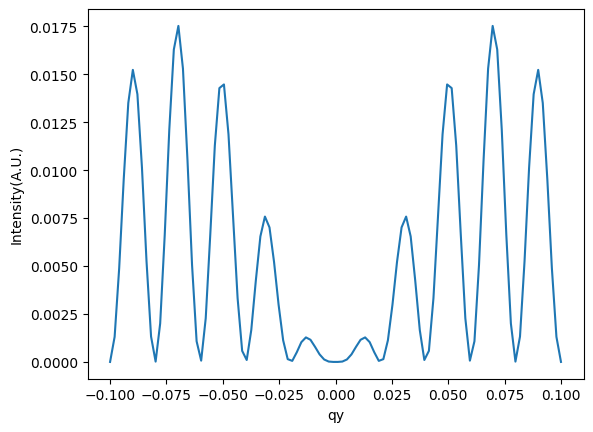

In [11]:
# Example Usage
# Define the cylinder dimensions
radius = 50.  # in arbitrary units
height = 100.  # in arbitrary units
density = 10.  # in arbitrary units

# Define the q-space grid
qys = np.linspace(-0.1, 0.1, 100)  # qy range
qzs = np.linspace(-0.1, 0.1, 100)  # qz range

# Create a simulation object
cylinder_sim = CylinderSimulation(qys=qys, qzs=qzs)

# Calculate the intensity
intensity = cylinder_sim.simulate_diffraction(params={'radius': radius, 'height': height, 'density': density})

# Output the intensity array
import matplotlib.pyplot as plt
plt.plot(qys, intensity)
plt.xlabel('qy')
plt.ylabel('Intensity(A.U.)')

Now we will use the generated data to simulate the diffraction and we can use the `Fitter` class to fit. We will give a initial guess that is close to the actual values. How close is determined by the domain of search fixed by your `multipliers` in `rescale_fitparams` and value of `sigma` for `cmaes` method. In this case in the condition of choosing your initial guess is that: `sigma * multipliers + initial_guess < real_value < sigma * multipliers - initial_guess`.

In [35]:
from cdsaxs.fitter import Fitter
Simulation2 = CylinderSimulation(qys=qys, qzs=qzs, initial_guess={'radius': 51, 'height': 101, 'density': 8})

Fitter1 = Fitter(Simulation=Simulation2, exp_data=intensity)

best_fit, best_fitness = Fitter1.cmaes(sigma=1, ngen=80, popsize=300, mu=10, n_default=3, restarts=0, tolhistfun=10E-5, ftarget=None, restart_from_best=True, verbose=False)

print(best_fit)

Iteration terminated due to ngen criterion after 80 gens
      radius  height    density
0  50.011961   100.0  10.069623
